In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow scikit-learn


In [3]:
!unzip "/content/drive/My Drive/DataSet.zip" -d "/content"


Streaming output truncated to the last 5000 lines.
  inflating: /content/DataSet/train/images/FisheyeCamera_1_00312_png.rf.0f026f535efd3c25c4c3bd985f169bdd.jpg  
  inflating: /content/DataSet/valid/images/00014_00009_00012_png.rf.02ffbac072397fe4f36979ba80f74fb9.jpg  
  inflating: /content/DataSet/valid/images/000297_jpg.rf.b373c5e86c5e0fcfe7a99082beeba1d2.jpg  
  inflating: /content/DataSet/valid/images/000352_jpg.rf.d63e34658183df08ad20ef345a34795f.jpg  
  inflating: /content/DataSet/valid/images/000387_jpg.rf.7119e3f9c6a97ec54b1de9f62fd6f7b2.jpg  
  inflating: /content/DataSet/valid/images/000242_jpg.rf.ce0b1a3828ba64c185b3638cd90951c6.jpg  
  inflating: /content/DataSet/valid/images/000354_jpg.rf.b7ccfe0e9fd239ec28a6518202c7c531.jpg  
  inflating: /content/DataSet/valid/images/000319_jpg.rf.1fd32a8ec85d8ece29bdcc792fdf960c.jpg  
  inflating: /content/DataSet/valid/images/000330_jpg.rf.e8b0af092d57c4f34925bb7177a0b474.jpg  
  inflating: /content/DataSet/valid/images/00014_00010_0000

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess the images and labels
def load_data(data_dir, target_size=(416, 416), num_classes=15):
    images = []
    labels = []

    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    for image_file in os.listdir(images_dir):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(images_dir, image_file)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)

            # Match image with corresponding label
            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(labels_dir, label_file)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if lines:  # Ensure the label file is not empty
                        first_label = int(lines[0].split()[0])  # Use the first class_id
                        labels.append(first_label)
                    else:
                        print(f"Empty label file for image: {image_file}")
                        labels.append(0)  # Default to class 0 if no label
            else:
                print(f"Label file missing for image: {image_file}")
                labels.append(0)  # Default to class 0 if no label

    images = np.array(images)
    labels = np.array(labels)

    print(f"Images loaded: {len(images)}, Labels loaded: {len(labels)}")
    labels = to_categorical(labels, num_classes=num_classes)

    return images, labels



In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
# Load training, validation, and testing datasets
train_dir = '/content/DataSet/train'
val_dir = '/content/DataSet/valid'
test_dir = '/content/DataSet/test'

X_train, y_train = load_data('/content/DataSet/train', target_size=(416, 416), num_classes=15)
X_val, y_val = load_data('/content/DataSet/valid', target_size=(416, 416), num_classes=15)
X_test, y_test = load_data('/content/DataSet/test', target_size=(416, 416), num_classes=15)
# Check shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

In [6]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataGenerator(Sequence):
    def __init__(self, data_dir, target_size=(416, 416), num_classes=15, batch_size=32):
        self.images_dir = os.path.join(data_dir, 'images')
        self.labels_dir = os.path.join(data_dir, 'labels')
        self.target_size = target_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []

        for image_file in batch_files:
            image_path = os.path.join(self.images_dir, image_file)
            img = load_img(image_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)

            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if lines:
                        first_label = int(lines[0].split()[0])
                        labels.append(first_label)
                    else:
                        images.pop()
            else:
                images.pop()

        images = np.array(images)
        labels = np.array(labels)
        labels = np.eye(self.num_classes)[labels]
        return images, labels
    def get_all_labels(self):
        all_labels = []
        for image_file in self.image_files:
            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        all_labels.append(class_id)
                        break
        return np.array(all_labels)




In [ ]:
#with corp
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
class DataGenerator(Sequence):
    def __init__(self, data_dir, target_size=(90, 90), num_classes=15, batch_size=32):
        self.images_dir = os.path.join(data_dir, 'images')
        self.labels_dir = os.path.join(data_dir, 'labels')
        self.target_size = target_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []

        for image_file in batch_files:
            image_path = os.path.join(self.images_dir, image_file)
            img = Image.open(image_path)
            img_width, img_height = img.size

            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id, x_center, y_center, width, height = map(float, line.split())

                        x_center *= img_width
                        y_center *= img_height
                        width *= img_width
                        height *= img_height

                        x_min = int(x_center - width / 2)
                        y_min = int(y_center - height / 2)
                        x_max = int(x_center + width / 2)
                        y_max = int(y_center + height / 2)

                        cropped_img = img.crop((x_min, y_min, x_max, y_max))
                        cropped_img = cropped_img.resize(self.target_size)
                        cropped_img_array = img_to_array(cropped_img) / 255.0

                        images.append(cropped_img_array)
                        labels.append(int(class_id))
            else:
                print(f"Label file missing for {image_file}")

        images = np.array(images)
        labels = np.array(labels)
        labels = np.eye(self.num_classes)[labels]
        return images, labels


    def get_all_labels(self):
        all_labels = []
        for image_file in self.image_files:
            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        all_labels.append(class_id)
        return np.array(all_labels)




In [7]:

train_dir = '/content/DataSet/train'
val_dir = '/content/DataSet/valid'
test_dir = '/content/DataSet/test'

batch_size = 32
train_gen = DataGenerator(train_dir, target_size=(416, 416), num_classes=15, batch_size=batch_size)
val_gen = DataGenerator(val_dir, target_size=(416, 416), num_classes=15, batch_size=batch_size)
test_gen = DataGenerator(test_dir, target_size=(416, 416), num_classes=15, batch_size=batch_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(416, 416, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='loss',
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)

In [9]:
#using this model **************************************************
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(416, 416, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='loss',
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 77s 548ms/step - accuracy: 0.1526 - loss: 2.5709 - val_accuracy: 0.3246 - val_loss: 2.0612
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.3452 - loss: 2.0140 - val_accuracy: 0.4045 - val_loss: 1.8153
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.4479 - loss: 1.7062 - val_accuracy: 0.4482 - val_loss: 1.6785
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.5496 - loss: 1.3719 - val_accuracy: 0.5131 - val_loss: 1.6048
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.6613 - loss: 1.0610 - val_accuracy: 0.5443 - val_loss: 1.5890
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 231ms/step - accuracy: 0.7672 - loss: 0.7609 - val_accuracy: 0.5943 - val_loss: 1.4411
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - accuracy: 0.8619 - loss: 0.5044 - val_accuracy: 0.5893 - val_loss: 1.6445
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.8877 - loss: 0.3550 - val

In [11]:
model.save('traffic_signs_model_without_crop_64_29.keras')


In [12]:
test_loss, test_accuracy = model.evaluate(val_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.6771 - loss: 2.2712
Test Accuracy: 64.29%


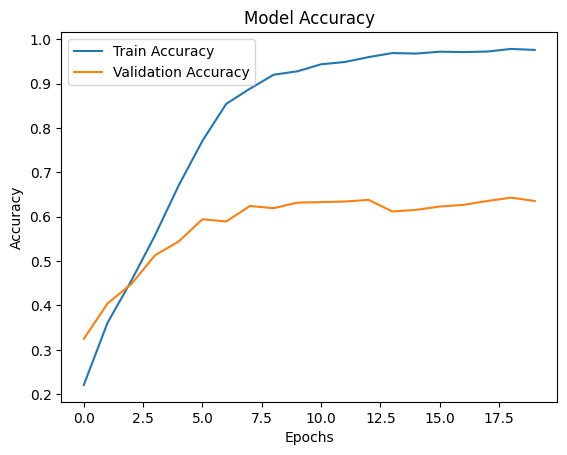

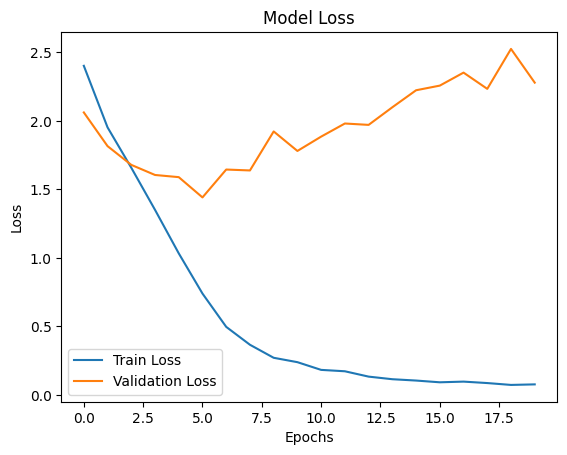

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


/content/DataSet/test/labels


In [14]:
import numpy as np

predictions = model.predict(test_gen, verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = []
for _, labels in test_gen:
    true_classes.extend(np.argmax(labels, axis=1))
    if len(true_classes) >= len(test_gen.image_files):
        break
true_classes = np.array(true_classes[:len(predicted_classes)])

print(f"Predicted: {predicted_classes[:10]}")
print(f"True: {true_classes[:10]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step
Predicted: [ 6 14  1  6  0  3 12 10 13 11]
True: [ 6 14  1  6  1  3 12 10 12  4]


In [15]:
all_test_labels = test_gen.get_all_labels()
print("All test labels:", len(all_test_labels))

All test labels: 637


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


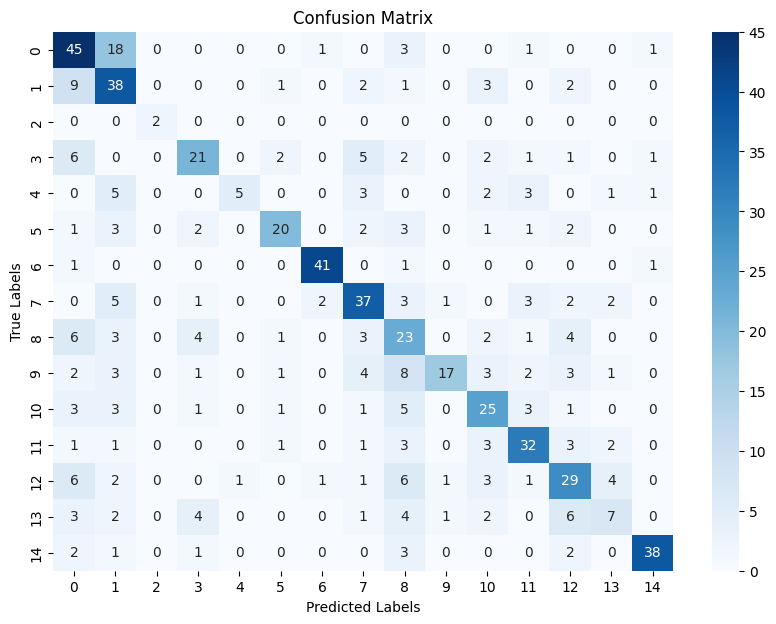

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_predictions = model.predict(test_gen, verbose=1)

test_predictions = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(all_test_labels, test_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_test_labels), yticklabels=np.unique(all_test_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

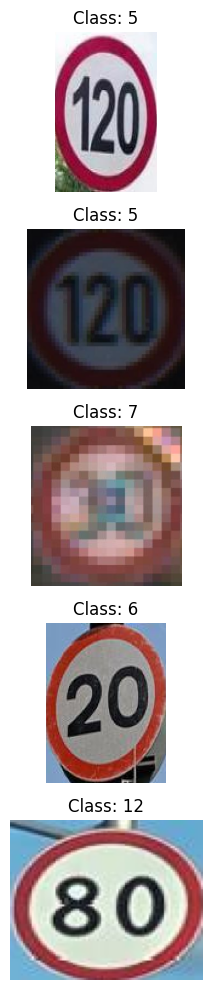

In [17]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def show_cropped_images(generator, num_samples=5):
    random_indices = random.sample(range(len(generator.image_files)), num_samples)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(random_indices):
        image_file = generator.image_files[idx]
        image_path = os.path.join(generator.images_dir, image_file)
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(generator.labels_dir, label_file)

        img = Image.open(image_path)
        img_width, img_height = img.size

        cropped_images = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height

                    left = int(x_center - width / 2)
                    upper = int(y_center - height / 2)
                    right = int(x_center + width / 2)
                    lower = int(y_center + height / 2)

                    cropped_image = img.crop((left, upper, right, lower))
                    cropped_images.append((cropped_image, class_id))

        for j, (cropped_image, class_id) in enumerate(cropped_images):
            plt.subplot(num_samples, len(cropped_images), i * len(cropped_images) + j + 1)
            plt.imshow(cropped_image)
            plt.axis('off')
            plt.title(f"Class: {class_id}")

    plt.tight_layout()
    plt.show()

show_cropped_images(test_gen, num_samples=5)
